# Indexing arXiv Papers with Citation Networks to Elasticsearch

This notebook demonstrates how to process and index arXiv academic papers along with their citation networks into Elasticsearch to create a powerful academic search engine. The process includes:

1. **Data Loading and Cleaning**: Loading arXiv metadata and citation network data, then cleaning and normalizing fields like titles, abstracts, authors, and categories.

2. **Citation Network Integration**: Enhancing paper metadata with citation information (papers cited by each paper and papers citing each paper).

3. **Text Processing**: Performing tokenization and TF-IDF calculation to prepare text for efficient searching.

4. **Elasticsearch Indexing**: Storing the enhanced dataset in Elasticsearch with appropriate mappings for optimal search performance.

The notebook uses two primary data sources:
- arXiv metadata from the [Cornell University arXiv dataset on Kaggle](https://www.kaggle.com/datasets/Cornell-University/arxiv/discussion/179819)
- Citation network data from [Matt Bierbaum's arXiv public datasets](https://github.com/mattbierbaum/arxiv-public-datasets/releases/tag/v0.2.0)

This integration enables powerful academic search capabilities, allowing users to find papers not just by content but also by their position in the citation network, revealing influential papers and research connections.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Arxiv-Index-into-Elasticsearch") \
    .master("local[*]") \
    .config("spark.jars.packages", "org.elasticsearch:elasticsearch-spark-30_2.12:8.8.2") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

Next, load the JSON dataset into a DataFrame. The file is in JSONL format, so each line is a separate JSON record. We can use spark.read.json which will parse each line into a row.

In [2]:
# Path to the JSON file (adjust if necessary)
metadata_path = "../data/arxiv-metadata-oai-snapshot.json"

# Load the JSON file into a DataFrame, selecting only the fields of interest
metadata_df = spark.read.json(metadata_path) \
        .select("id", "title", "abstract", "authors", "categories")

# Print the schema and number of records to verify
metadata_df.printSchema()
print("Total records:", metadata_df.count())
metadata_df.show(5)

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- categories: string (nullable = true)

Total records: 2694879
+---------+--------------------+--------------------+--------------------+---------------+
|       id|               title|            abstract|             authors|     categories|
+---------+--------------------+--------------------+--------------------+---------------+
|0704.0001|Calculation of pr...|  A fully differe...|C. Bal\'azs, E. L...|         hep-ph|
|0704.0002|Sparsity-certifyi...|  We describe a n...|Ileana Streinu an...|  math.CO cs.CG|
|0704.0003|The evolution of ...|  The evolution o...|         Hongjun Pan| physics.gen-ph|
|0704.0004|A determinant of ...|  We show that a ...|        David Callan|        math.CO|
|0704.0005|From dyadic $\Lam...|  In this paper w...|Wael Abu-Shammala...|math.CA math.FA|
+---------+--------------------+-------------------

This will load the metadata. The select filters the DataFrame to only relevant columns to save memory. The schema should list each field and their types (all should be strings, except possibly categories could be a string of space-separated categories). 

You should see that 2.6+ million records were loaded (which may take a bit of time for the count). 


Now let's clean and normalize the fields:
- Remove any newline characters or excessive whitespace in titles and abstracts.
- Convert text to lowercase for consistent processing.
- Clean the authors field (e.g., remove line breaks, unify separators).
- Split the categories field into an array of individual category codes, since categories in the raw data might be a single string of space-separated codes​.

We'll use PySpark SQL functions to do this in a vectorized way

In [3]:
from pyspark.sql.functions import regexp_replace, trim, lower, split

# Remove newlines and excessive whitespace in title and abstract, and trim
df_clean = metadata_df.withColumn("title", trim(regexp_replace("title", r"[\r\n]+", " "))) \
             .withColumn("abstract", trim(regexp_replace("abstract", r"[\r\n]+", " "))) \
             .withColumn("title", regexp_replace("title", r"\s+", " ")) \
             .withColumn("abstract", regexp_replace("abstract", r"\s+", " "))

# Optionally, make text lowercase (for consistent analysis, though Elasticsearch will handle casing)
df_clean = df_clean.withColumn("title", lower("title")) \
                   .withColumn("abstract", lower("abstract")) \
                   .withColumn("authors", lower("authors"))

# Normalize authors: replace ' and ' with comma, remove trailing ' and'
df_clean = df_clean.withColumn("authors", regexp_replace("authors", r"\sand\s", ", ")) \
                   .withColumn("authors", regexp_replace("authors", r"\s+", " "))

# Split categories into array of category codes
df_clean = df_clean.withColumn("categories", split("categories", " "))


df_clean.printSchema()
print("Total records:", df_clean.count())
df_clean.show(5)

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = false)

Total records: 2694879
+---------+--------------------+--------------------+--------------------+------------------+
|       id|               title|            abstract|             authors|        categories|
+---------+--------------------+--------------------+--------------------+------------------+
|0704.0001|calculation of pr...|a fully different...|c. bal\'azs, e. l...|          [hep-ph]|
|0704.0002|sparsity-certifyi...|we describe a new...|ileana streinu, l...|  [math.CO, cs.CG]|
|0704.0003|the evolution of ...|the evolution of ...|         hongjun pan|  [physics.gen-ph]|
|0704.0004|a determinant of ...|we show that a de...|        david callan|         [math.CO]|
|0704.0005|from dyadic $\lam...|in this paper we ...|wael abu-shammala...

The above transformations:
- Use regexp_replace to replace newlines (\r\n) with spaces and condense multiple spaces to one.
- Lowercase the text in title, abstract, authors.
- In authors, attempt to replace the word " and " with a comma+space, so that authors like "Smith and Doe" become "Smith, Doe", then all multiple spaces condensed. This way authors are separated uniformly by commas.
- Split the categories string on spaces into an array (e.g., "cs.AI cs.CL" becomes ["cs.AI","cs.CL"]).

#### Load Citation Network Data
Let's load the citation network data. We'll use the edge list format as it's more suitable for our needs.

In [4]:
# Path to the citation network data
references_path = "../data/internal-references-edges.parquet"

# Load the citation data
references_df = spark.read.parquet(references_path)

print("Citation network data loaded")
print(f"Total edges: {references_df.count()}")
references_df.printSchema()
references_df.show(5)

Citation network data loaded
Total edges: 6849633
root
 |-- source_id: string (nullable = true)
 |-- target_id: string (nullable = true)

+----------------+----------------+
|       source_id|       target_id|
+----------------+----------------+
|alg-geom/9412010|alg-geom/9509005|
|alg-geom/9412020|alg-geom/9505009|
|alg-geom/9412012|alg-geom/9407002|
|alg-geom/9412017|alg-geom/9411005|
|alg-geom/9412017|alg-geom/9310001|
+----------------+----------------+
only showing top 5 rows



Let's explore the citation data to understand its structure and coverage.

In [5]:
from pyspark.sql.functions import col

# Count unique source papers (papers that cite others)
unique_sources = references_df.select("source_id").distinct().count()
print(f"Number of papers that cite others: {unique_sources}")

# Count unique target papers (papers that are cited)
unique_targets = references_df.select("target_id").distinct().count()
print(f"Number of papers that are cited: {unique_targets}")

# Distribution of citation counts (how many papers each paper cites)
citation_counts = references_df.groupBy("source_id").count().withColumnRenamed("count", "num_citations")
citation_counts.describe().show()

# Show papers with the most outgoing citations
print("Papers that cite the most other papers:")
citation_counts.orderBy(col("num_citations").desc()).show(10)

Number of papers that cite others: 734454
Number of papers that are cited: 737153
+-------+-----------------+-----------------+
|summary|        source_id|    num_citations|
+-------+-----------------+-----------------+
|  count|           734454|           734454|
|   mean|1378.148942504266|9.326156573454567|
| stddev|339.5324177500846|20.91779079377801|
|    min|        0704.0001|                1|
|    max| supr-con/9607007|             5063|
+-------+-----------------+-----------------+

Papers that cite the most other papers:
+----------------+-------------+
|       source_id|num_citations|
+----------------+-------------+
|quant-ph/0012089|         5063|
|       1404.3723|         2398|
|      1806.05195|         1679|
|      1610.07922|         1399|
|      1812.07638|         1356|
|       1004.3169|         1265|
|      1612.07233|         1253|
|      1606.00180|         1102|
|       1106.2476|          968|
|      1707.02046|          940|
+----------------+-------------+
o

### Join Metadata with Citation Data
Now, let's enhance the metadata with citation information. We'll create two new columns:
cited_papers: List of papers that this paper cites
cited_by_papers: List of papers that cite this paper

In [6]:
from pyspark.sql.functions import explode, array_contains, when, lit, size


# Group citations by source to get "cited_papers" for each paper
outgoing_citations = references_df.groupBy("source_id") \
    .agg({"target_id": "collect_list"}) \
    .withColumnRenamed("collect_list(target_id)", "cited_papers")

# Group citations by target to get "cited_by_papers" for each paper
incoming_citations = references_df.groupBy("target_id") \
    .agg({"source_id": "collect_list"}) \
    .withColumnRenamed("collect_list(source_id)", "cited_by_papers") \
    .withColumnRenamed("target_id", "id")

# Join metadata with outgoing citations
enhanced_df = metadata_df.join(outgoing_citations, metadata_df["id"] == outgoing_citations["source_id"], "left") \
    .drop("source_id")

# Join with incoming citations
enhanced_df = enhanced_df.join(incoming_citations, "id", "left")

# Replace null citation lists with empty arrays
enhanced_df = enhanced_df \
    .withColumn("cited_papers", when(col("cited_papers").isNull(), lit([])).otherwise(col("cited_papers"))) \
    .withColumn("cited_by_papers", when(col("cited_by_papers").isNull(), lit([])).otherwise(col("cited_by_papers")))

# Add citation count columns for easier filtering
enhanced_df = enhanced_df \
    .withColumn("num_cited_papers", size(col("cited_papers"))) \
    .withColumn("num_cited_by_papers", size(col("cited_by_papers")))

print("Enhanced metadata created")
enhanced_df.printSchema()
enhanced_df.show(5, truncate=80)

Enhanced metadata created
root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- cited_papers: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- cited_by_papers: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- num_cited_papers: integer (nullable = false)
 |-- num_cited_by_papers: integer (nullable = false)

+---------+------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+-----------------+------------------------------------+--------------------------------------------------------------------------------+----------------+-------------------+
|       id|                                                             

### Filter to Keep Only Papers with Citations
Since the reference data only goes up to 2019, we'll filter to keep only papers that have citation information.

In [7]:
# Filter to keep only papers that have outgoing citations
papers_with_citations = enhanced_df.filter(col("num_cited_papers") > 0)

print(f"Papers with citation information: {papers_with_citations.count()}")
print(f"Percentage of original dataset: {papers_with_citations.count() / metadata_df.count() * 100:.2f}%")

papers_with_citations.show(5, truncate=80)

Papers with citation information: 734465
Percentage of original dataset: 27.25%
+---------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+---------------------------------------------------------------+-----------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+----------------+-------------------+
|       id|                                                                           title|                                                                        abstract|                                                        authors|       categories|                                                                    cited_papers|                                                                 cited_by_papers|num_cited_papers|num_cited_by_papers|
+---------

### Analyze the Enhanced Dataset
Let's analyze the enhanced dataset to understand the citation patterns.


In [8]:
# Distribution of outgoing citations
print("Distribution of outgoing citations (papers cited by each paper):")
papers_with_citations.groupBy("num_cited_papers").count().orderBy("num_cited_papers").show(20)

# Distribution of incoming citations
print("Distribution of incoming citations (papers citing each paper):")
papers_with_citations.groupBy("num_cited_by_papers").count().orderBy("num_cited_by_papers").show(20)

# Find the most cited papers
print("Most cited papers:")
papers_with_citations.select("id", "title", "num_cited_by_papers") \
    .orderBy(col("num_cited_by_papers").desc()) \
    .show(10, truncate=80)

Distribution of outgoing citations (papers cited by each paper):
+----------------+------+
|num_cited_papers| count|
+----------------+------+
|               1|224285|
|               2|123909|
|               3| 76260|
|               4| 49309|
|               5| 33928|
|               6| 24489|
|               7| 18470|
|               8| 14398|
|               9| 11818|
|              10|  9663|
|              11|  8197|
|              12|  7217|
|              13|  6248|
|              14|  5712|
|              15|  5225|
|              16|  4818|
|              17|  4439|
|              18|  4284|
|              19|  4037|
|              20|  3777|
+----------------+------+
only showing top 20 rows

Distribution of incoming citations (papers citing each paper):
+-------------------+------+
|num_cited_by_papers| count|
+-------------------+------+
|                  0|243849|
|                  1|121518|
|                  2| 72760|
|                  3| 48082|
|                  

Let's visualize how much of the original dataset has citation information.

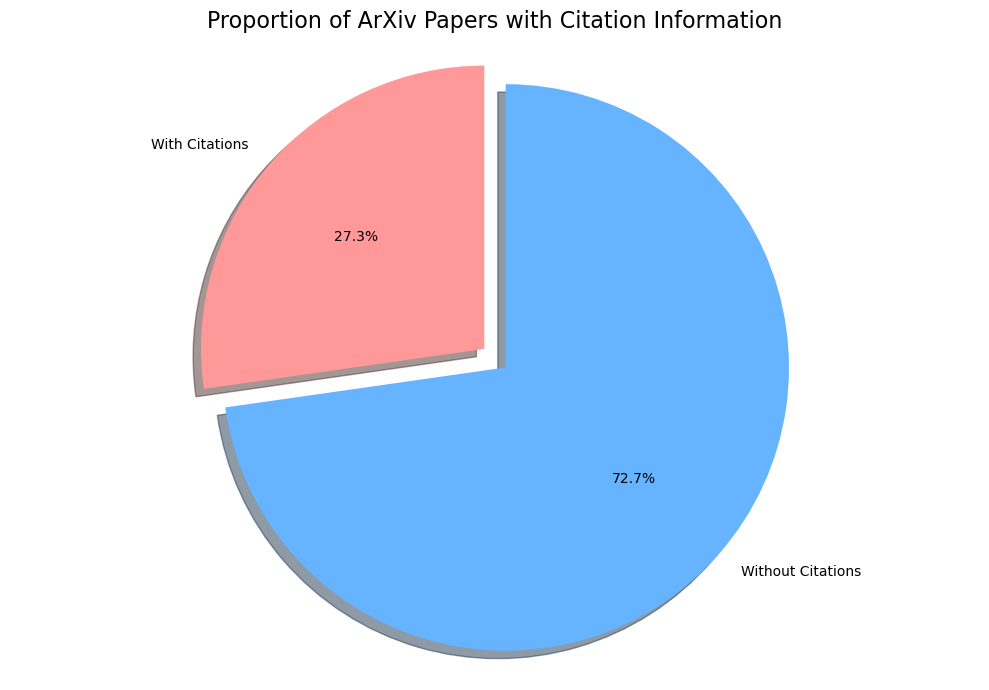

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Calculate the counts
with_citations = papers_with_citations.count()
without_citations = metadata_df.count() - with_citations

# Create a pie chart
plt.figure(figsize=(10, 7))
plt.pie([with_citations, without_citations], 
        labels=['With Citations', 'Without Citations'],
        autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff'],
        explode=(0.1, 0),
        shadow=True,
        startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of ArXiv Papers with Citation Information', fontsize=16)
plt.tight_layout()
plt.show()

Let's create visualizations to better understand the citation patterns.

+--------------+--------------------------------------------------------------------------------+-------------------+
|            id|                                                                           title|num_cited_by_papers|
+--------------+--------------------------------------------------------------------------------+-------------------+
|hep-th/9711200|             The Large N Limit of Superconformal Field Theories and Supergravity|               9866|
|hep-th/9802150|                                             Anti De Sitter Space And Holography|               6600|
|hep-th/9802109|                        Gauge Theory Correlators from Non-Critical String Theory|               5819|
|     1412.6980|                                      Adam: A Method for Stochastic Optimization|               5374|
|    1502.01589|                              Planck 2015 results. XIII. Cosmological parameters|               4484|
|     1207.7214|Observation of a new particle in the sea

/tmp/ipykernel_5394/3159241247.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_cited_papers', y='count', data=outgoing_dist_pd.head(20), palette='viridis')


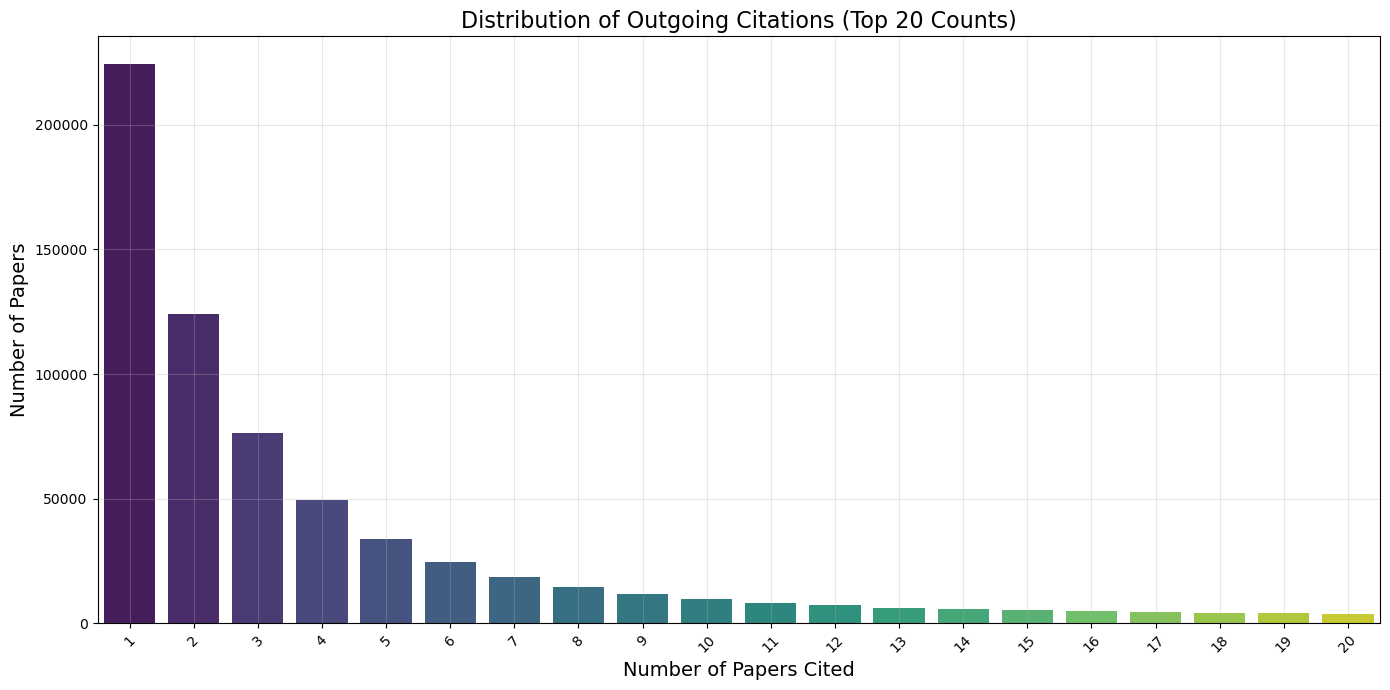

/tmp/ipykernel_5394/3159241247.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_cited_by_papers', y='count', data=incoming_dist_pd.head(20), palette='magma')


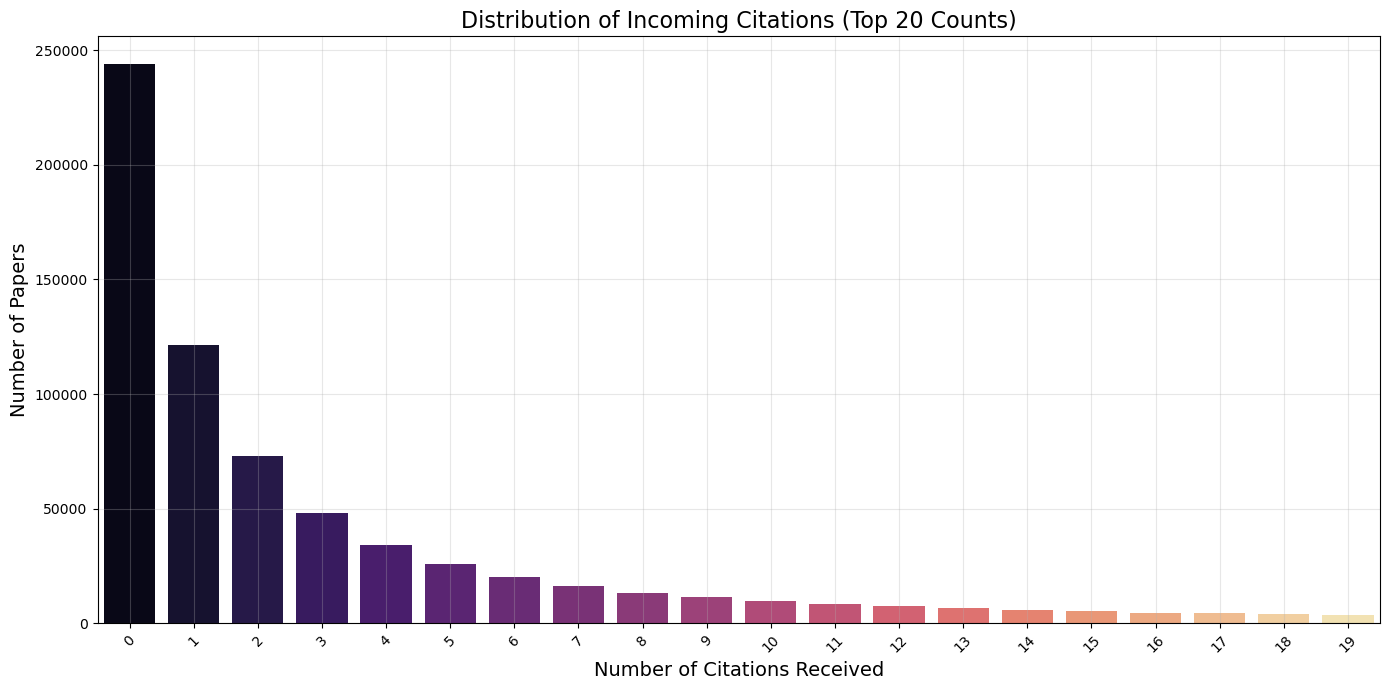

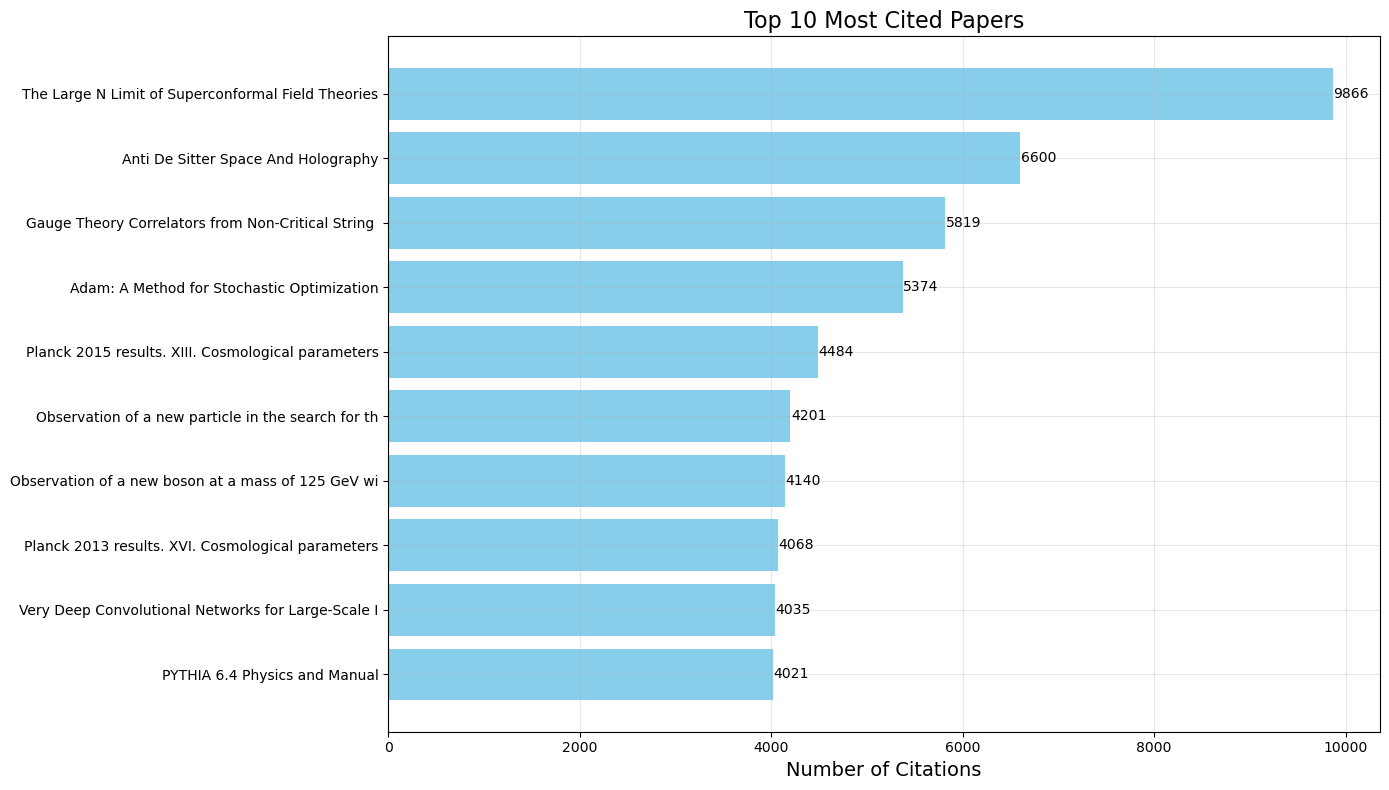

In [10]:
# Distribution of outgoing citations
outgoing_dist = papers_with_citations.groupBy("num_cited_papers").count().orderBy("num_cited_papers")

# Distribution of incoming citations
incoming_dist = papers_with_citations.groupBy("num_cited_by_papers").count().orderBy("num_cited_by_papers")

# Find the most cited papers
most_cited = papers_with_citations.select("id", "title", "num_cited_by_papers") \
    .orderBy(col("num_cited_by_papers").desc()) \
    .limit(10)
most_cited.show(truncate=80)

# Convert to Pandas for visualization
outgoing_dist_pd = outgoing_dist.toPandas()
incoming_dist_pd = incoming_dist.toPandas()
most_cited_pd = most_cited.toPandas()

# Plot outgoing citations distribution (top 20)
plt.figure(figsize=(14, 7))
sns.barplot(x='num_cited_papers', y='count', data=outgoing_dist_pd.head(20), palette='viridis')
plt.title('Distribution of Outgoing Citations (Top 20 Counts)', fontsize=16)
plt.xlabel('Number of Papers Cited', fontsize=14)
plt.ylabel('Number of Papers', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot incoming citations distribution (top 20)
plt.figure(figsize=(14, 7))
sns.barplot(x='num_cited_by_papers', y='count', data=incoming_dist_pd.head(20), palette='magma')
plt.title('Distribution of Incoming Citations (Top 20 Counts)', fontsize=16)
plt.xlabel('Number of Citations Received', fontsize=14)
plt.ylabel('Number of Papers', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot most cited papers
plt.figure(figsize=(14, 8))
bars = plt.barh(most_cited_pd['title'].str[:50], most_cited_pd['num_cited_by_papers'], color='skyblue')
plt.xlabel('Number of Citations', fontsize=14)
plt.title('Top 10 Most Cited Papers', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.grid(True, alpha=0.3)

# Add citation counts as text labels
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
             str(most_cited_pd['num_cited_by_papers'].iloc[i]),
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

Let's examine how citation patterns vary across different research categories.

In [11]:
# Extract the primary category for each paper
from pyspark.sql.functions import split, element_at

# Assuming categories is a string like "cs.AI math.ST" or an array
papers_with_category = papers_with_citations.withColumn(
    "primary_category", 
    when(col("categories").isNull(), lit("unknown"))
    .otherwise(element_at(split(col("categories"), " "), 1))
)

# Get citation statistics by category
category_stats = papers_with_category.groupBy("primary_category").agg(
    {"num_cited_papers": "avg", "num_cited_by_papers": "avg", "id": "count"}
).withColumnRenamed("avg(num_cited_papers)", "avg_outgoing_citations") \
 .withColumnRenamed("avg(num_cited_by_papers)", "avg_incoming_citations") \
 .withColumnRenamed("count(id)", "paper_count") \
 .orderBy(col("paper_count").desc())

# Show the top categories
category_stats.show(20, truncate=80)

+------------------+----------------------+----------------------+-----------+
|  primary_category|avg_outgoing_citations|avg_incoming_citations|paper_count|
+------------------+----------------------+----------------------+-----------+
|            hep-ph|    21.668584474885844|    18.025422374429223|      87600|
|            hep-th|    24.861314906443724|     23.69722174827959|      70332|
|          astro-ph|     5.402416891682528|      9.10904785091408|      45182|
|          quant-ph|     4.541046626984127|    3.7265128968253967|      40320|
|             gr-qc|    14.670412217531661|    10.107244847280855|      32216|
|       astro-ph.CO|     18.47119787900699|    11.188768377922392|      20745|
|   cond-mat.str-el|    3.8515212028662047|     2.997885586749677|      17026|
| cond-mat.mes-hall|     2.734331702140204|     2.032014621779376|      16961|
|           math.AG|    3.9250833119712896|    3.5224301461163803|      15604|
|           nucl-th|      8.04148735879505|     6.27

Let's visualize how citation patterns vary across different research categories

/tmp/ipykernel_5394/1538162972.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_outgoing_citations', y='primary_category', data=top_categories,
/tmp/ipykernel_5394/1538162972.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_incoming_citations', y='primary_category', data=top_categories,


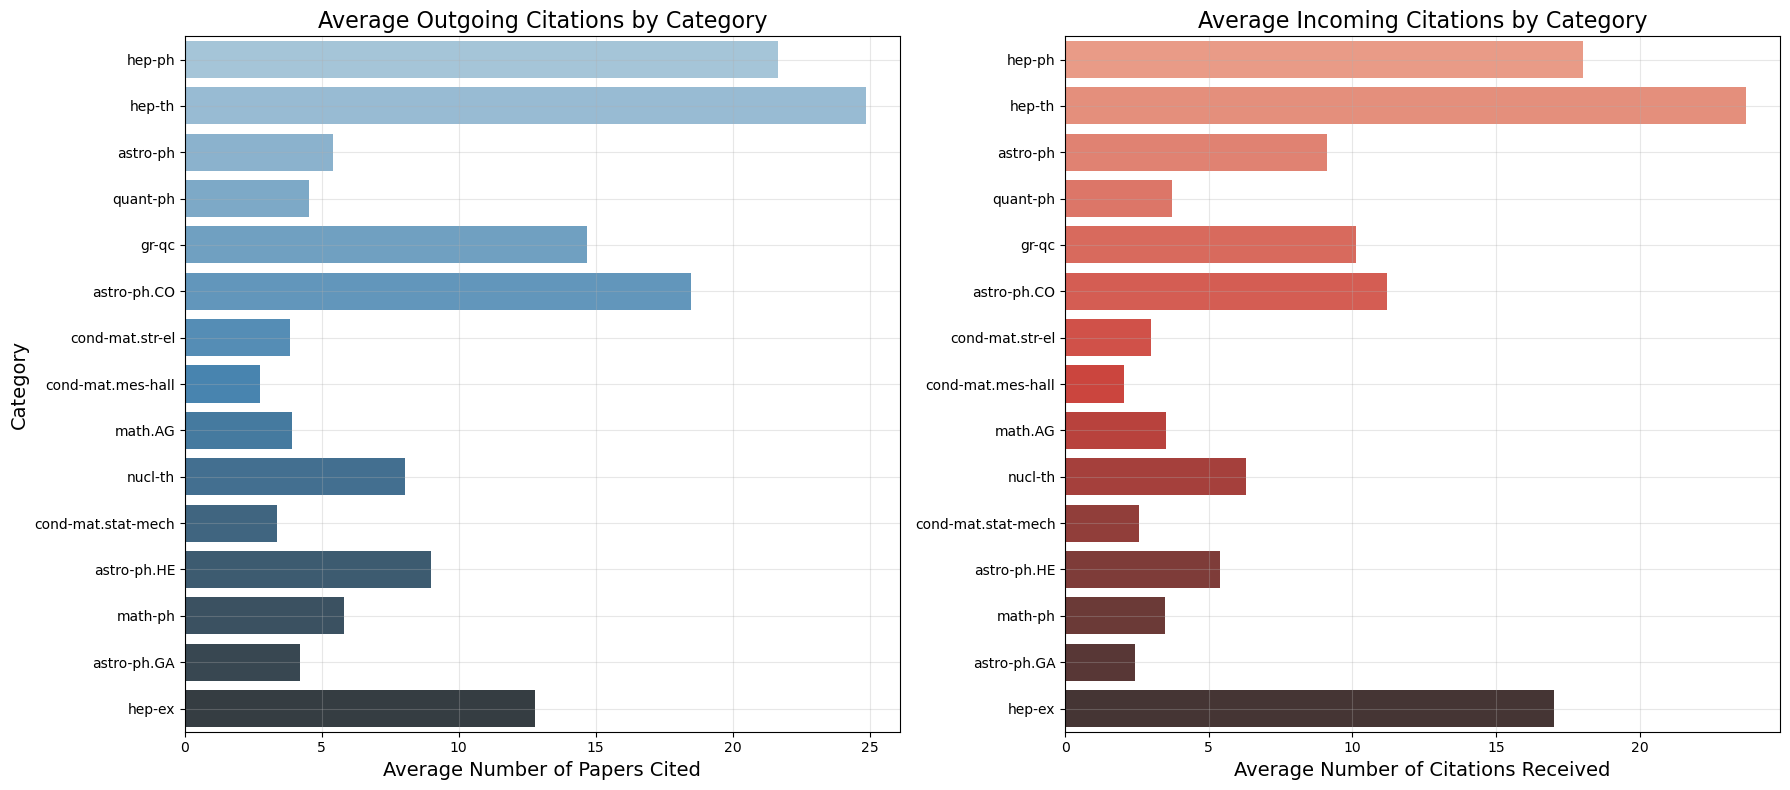

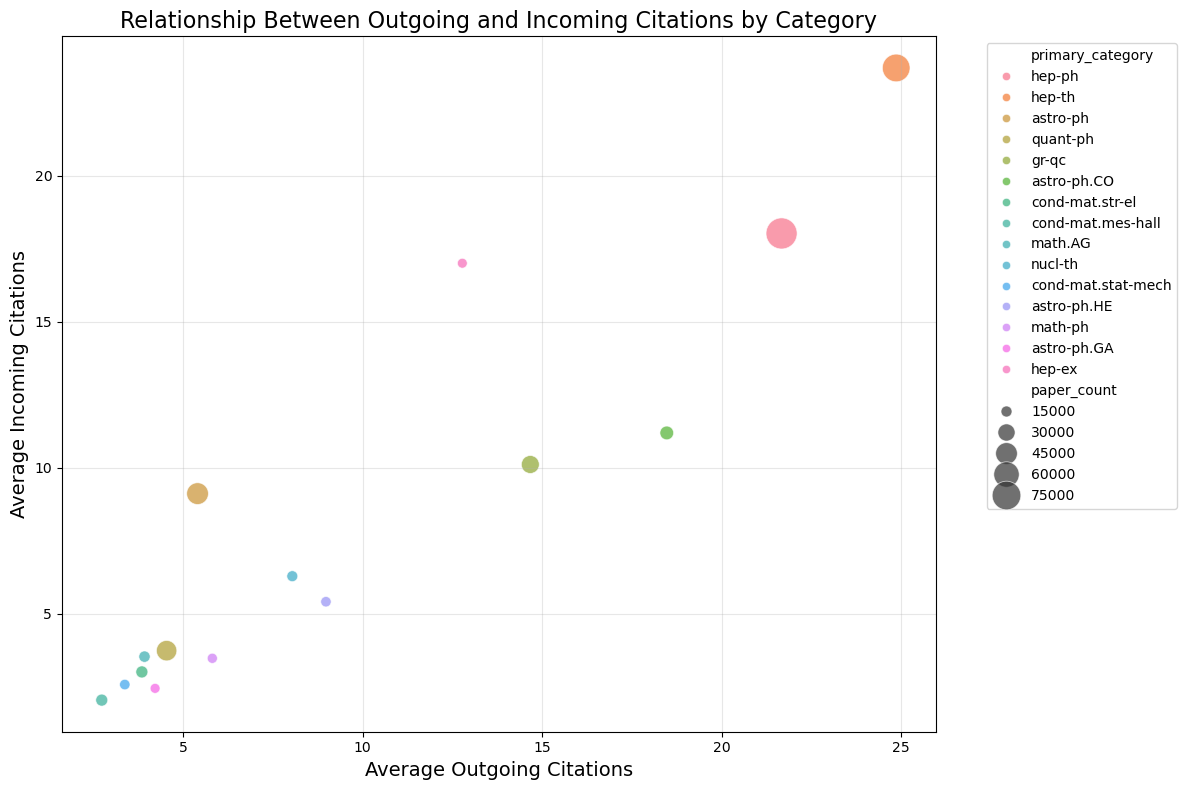

In [12]:
# Convert to Pandas for visualization
category_stats_pd = category_stats.toPandas()

# Filter to top 15 categories by paper count
top_categories = category_stats_pd.nlargest(15, 'paper_count')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot average outgoing citations by category
sns.barplot(x='avg_outgoing_citations', y='primary_category', data=top_categories, 
            palette='Blues_d', ax=ax1)
ax1.set_title('Average Outgoing Citations by Category', fontsize=16)
ax1.set_xlabel('Average Number of Papers Cited', fontsize=14)
ax1.set_ylabel('Category', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot average incoming citations by category
sns.barplot(x='avg_incoming_citations', y='primary_category', data=top_categories, 
            palette='Reds_d', ax=ax2)
ax2.set_title('Average Incoming Citations by Category', fontsize=16)
ax2.set_xlabel('Average Number of Citations Received', fontsize=14)
ax2.set_ylabel('')  # No y-label for the second plot
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a scatter plot to show the relationship between outgoing and incoming citations
plt.figure(figsize=(12, 8))
sns.scatterplot(x='avg_outgoing_citations', y='avg_incoming_citations', 
                size='paper_count', sizes=(50, 500), alpha=0.7, 
                hue='primary_category', data=top_categories)
plt.title('Relationship Between Outgoing and Incoming Citations by Category', fontsize=16)
plt.xlabel('Average Outgoing Citations', fontsize=14)
plt.ylabel('Average Incoming Citations', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The first pair of bar charts shows the average number of outgoing and incoming citations for the top 15 categories.
The scatter plot reveals the relationship between outgoing and incoming citations, with the size of each point representing the number of papers in that category.

## Prepare for Elasticsearch Indexing
Now, let's prepare the data for indexing in Elasticsearch. We'll need to ensure the data is in a format that Elasticsearch can handle efficiently.

In [13]:
# Convert array columns to strings for better Elasticsearch indexing
from pyspark.sql.functions import array_join

# First, let's check what columns are actually available
print("Available columns:")
print(papers_with_citations.columns)

# Create a version optimized for Elasticsearch
es_df = papers_with_citations \
    .withColumn("cited_papers_str", array_join("cited_papers", ",")) \
    .withColumn("cited_by_papers_str", array_join("cited_by_papers", ","))

# Keep both array and string versions for flexibility, but remove 'update_date' since it doesn't exist
es_df = es_df.select(
    "id", "title", "abstract", "authors", "categories",
    "cited_papers", "cited_by_papers", 
    "cited_papers_str", "cited_by_papers_str",
    "num_cited_papers", "num_cited_by_papers"
)

print("Data prepared for Elasticsearch")
es_df.printSchema()
es_df.show(5, truncate=80)

Available columns:
['id', 'title', 'abstract', 'authors', 'categories', 'cited_papers', 'cited_by_papers', 'num_cited_papers', 'num_cited_by_papers']
Data prepared for Elasticsearch
root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- cited_papers: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- cited_by_papers: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- cited_papers_str: string (nullable = true)
 |-- cited_by_papers_str: string (nullable = true)
 |-- num_cited_papers: integer (nullable = false)
 |-- num_cited_by_papers: integer (nullable = false)

+---------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+----------------------------------------------------------

### Save the Enhanced Dataset
Let's save the enhanced dataset for future use.

In [14]:
# Save the enhanced dataset as Parquet
output_path = "../data/arxiv_with_citations.parquet"
es_df.write.mode("overwrite").parquet(output_path)

print(f"Enhanced dataset saved to {output_path}")

Enhanced dataset saved to ../data/arxiv_with_citations.parquet


## Index in Elasticsearch
Let's index the data in elasticsearch.

First, lets check if we can connect to elasticsearch.

In [15]:
# Test connection to Elasticsearch using the container name
import requests
import json

try:
    # Try using the container name (DNS name in Docker network)
    response = requests.get("http://elasticsearch:9200")
    if response.status_code == 200:
        print("✅ Connection successful using container name!")
        print(f"Elasticsearch info: {json.dumps(response.json(), indent=2)}")
    else:
        print(f"❌ Elasticsearch returned status code: {response.status_code}")
except requests.exceptions.ConnectionError:
    print("❌ Could not connect using container name. Trying IP address...")
    try:
        # Try using the container IP address directly
        response = requests.get("http://172.17.0.2:9200")
        if response.status_code == 200:
            print("✅ Connection successful using IP address!")
            print(f"Elasticsearch info: {json.dumps(response.json(), indent=2)}")
        else:
            print(f"❌ Elasticsearch returned status code: {response.status_code}")
    except requests.exceptions.ConnectionError:
        print("❌ Could not connect to Elasticsearch using IP address either.")

✅ Connection successful using container name!
Elasticsearch info: {
  "name": "f72849631353",
  "cluster_name": "docker-cluster",
  "cluster_uuid": "TcmIgASUS4y0OhRVbGR7xw",
  "version": {
    "number": "8.8.2",
    "build_flavor": "default",
    "build_type": "docker",
    "build_hash": "98e1271edf932a480e4262a471281f1ee295ce6b",
    "build_date": "2023-06-26T05:16:16.196344851Z",
    "build_snapshot": false,
    "lucene_version": "9.6.0",
    "minimum_wire_compatibility_version": "7.17.0",
    "minimum_index_compatibility_version": "7.0.0"
  },
  "tagline": "You Know, for Search"
}


Finally, let's load the data into elasticsearch!

In [16]:
# Define Elasticsearch configuration
es_write_conf = {
    "es.nodes": "elasticsearch",  # Use the hostname instead of IP
    "es.port": "9200",
    "es.resource": "index_name",
    "es.nodes.wan.only": "true",  # Add this option
    "es.index.auto.create": "true",
    "es.mapping.id": "id",
    "es.write.operation": "index"
}

# Index the data in Elasticsearch
es_df.write \
    .format("org.elasticsearch.spark.sql") \
    .options(**es_write_conf) \
    .mode("overwrite") \
    .save()

print("Data indexed in Elasticsearch")

Data indexed in Elasticsearch


## Basic Search Tests

Let's start by testing basic search functionality in our Elasticsearch index. We'll perform a simple keyword search to find papers related to "neural networks" and examine the results.

In [29]:
# Testing Elasticsearch Results
import requests
import json
from pprint import pprint

# Define the Elasticsearch endpoint
es_host = "http://elasticsearch:9200"
index_name = "index_name"  # Use the same index name we used for indexing

# Function to pretty print JSON responses
# Function to pretty print JSON responses with truncation
def print_response(response, max_chars=1000):
    print(f"Status: {response.status_code}")
    if response.status_code == 200:
        # Get the JSON response as a string
        json_str = json.dumps(response.json(), indent=2)
        
        # Check if we need to truncate
        if len(json_str) > max_chars:
            # Truncate and add ellipsis
            print(json_str[:max_chars] + "...\n[Response truncated - total length: " + str(len(json_str)) + " chars]")
        else:
            # Print the full response
            pprint(response.json())
            
        # Always print the hit count for search results
        if 'hits' in response.json() and 'total' in response.json()['hits']:
            total = response.json()['hits']['total']
            if isinstance(total, dict) and 'value' in total:  # ES 7.x format
                print(f"\nTotal hits: {total['value']}")
            else:  # ES 6.x format
                print(f"\nTotal hits: {total}")
    else:
        print(f"Error: {response.text}")


#Basic keyword search for "neural networks"
query = {
    "query": {
        "multi_match": {
            "query": "neural networks",
            "fields": ["title", "abstract"]
        }
    },
    "size": 5  # Limit to 5 results
}

response = requests.post(f"{es_host}/{index_name}/_search", json=query)
print_response(response)

Status: 200
{
  "took": 91,
  "timed_out": false,
  "_shards": {
    "total": 1,
    "successful": 1,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 10000,
      "relation": "gte"
    },
    "max_score": 14.044158,
    "hits": [
      {
        "_index": "index_name",
        "_id": "1703.00144",
        "_score": 14.044158,
        "_ignored": [
          "abstract.keyword"
        ],
        "_source": {
          "id": "1703.00144",
          "title": "Theoretical Properties for Neural Networks with Weight Matrices of Low\n  Displacement Rank",
          "abstract": "  Recently low displacement rank (LDR) matrices, or so-called structured\nmatrices, have been proposed to compress large-scale neural networks. Empirical\nresults have shown that neural networks with weight matrices of LDR matrices,\nreferred as LDR neural networks, can achieve significant reduction in space and\ncomputational complexity while retaining high accuracy. We formally study 

## Citation-Based Search Tests

Now let's test the citation-based search capabilities. We'll first find a highly-cited paper, then use its ID to find papers that cite it or papers that it cites.

In [30]:
# Find a highly-cited paper
query = {
    "query": {
        "bool": {
            "must": {
                "match": {
                    "abstract": "deep learning"
                }
            },
            "filter": {
                "range": {
                    "num_cited_by_papers": {
                        "gte": 100  # Papers cited by at least 100 others
                    }
                }
            }
        }
    },
    "size": 1,
    "sort": [
        {"num_cited_by_papers": {"order": "desc"}}
    ]
}

response = requests.post(f"{es_host}/{index_name}/_search", json=query)
print("Highly-cited paper:")
print_response(response)

# Extract the paper ID from the response
try:
    paper_id = response.json()['hits']['hits'][0]['_source']['id']
    print(f"\nSelected paper ID: {paper_id}")
except (KeyError, IndexError):
    paper_id = "1409.1556"  # Fallback to a known paper ID if the search fails
    print(f"\nUsing fallback paper ID: {paper_id}")

Highly-cited paper:
Status: 200
{
  "took": 71,
  "timed_out": false,
  "_shards": {
    "total": 1,
    "successful": 1,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 250,
      "relation": "eq"
    },
    "max_score": null,
    "hits": [
      {
        "_index": "index_name",
        "_id": "1409.1556",
        "_score": null,
        "_ignored": [
          "cited_by_papers_str.keyword",
          "abstract.keyword"
        ],
        "_source": {
          "id": "1409.1556",
          "title": "Very Deep Convolutional Networks for Large-Scale Image Recognition",
          "abstract": "  In this work we investigate the effect of the convolutional network depth on\nits accuracy in the large-scale image recognition setting. Our main\ncontribution is a thorough evaluation of networks of increasing depth using an\narchitecture with very small (3x3) convolution filters, which shows that a\nsignificant improvement on the prior-art configurations can be 

## Finding Papers That Cite a Specific Paper

Now that we have a paper ID, let's find papers that cite this paper. This demonstrates how our citation network integration enables relationship-based queries.

In [31]:
# Find papers that cite our selected paper
query = {
    "query": {
        "match": {
            "cited_papers_str": paper_id
        }
    },
    "size": 5
}

response = requests.post(f"{es_host}/{index_name}/_search", json=query)
print("Papers that cite our selected paper:")
print_response(response)

Papers that cite our selected paper:
Status: 200
{
  "took": 86,
  "timed_out": false,
  "_shards": {
    "total": 1,
    "successful": 1,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 239,
      "relation": "eq"
    },
    "max_score": 12.938051,
    "hits": [
      {
        "_index": "index_name",
        "_id": "1807.10760",
        "_score": 12.938051,
        "_ignored": [
          "abstract.keyword"
        ],
        "_source": {
          "id": "1807.10760",
          "title": "Deep nested level sets: Fully automated segmentation of cardiac MR\n  images in patients with pulmonary hypertension",
          "abstract": "  In this paper we introduce a novel and accurate optimisation method for\nsegmentation of cardiac MR (CMR) images in patients with pulmonary hypertension\n(PH). The proposed method explicitly takes into account the image features\nlearned from a deep neural network. To this end, we estimate simultaneous\nprobability maps over r

## Advanced Search: Combining Content and Citation Filters

Finally, let's demonstrate a more advanced search that combines content-based filtering with citation-based filtering. This query finds papers about "reinforcement learning" that cite papers about "deep learning".

In [45]:
# First, find papers about deep learning
deep_learning_query = {
    "query": {
        "multi_match": {
            "query": "deep learning",
            "fields": ["title", "abstract"]
        }
    },
    "size": 100,
    "_source": ["id"]  # Only return the IDs
}

response = requests.post(f"{es_host}/{index_name}/_search", json=deep_learning_query)
deep_learning_papers = []
if response.status_code == 200:
    for hit in response.json()['hits']['hits']:
        deep_learning_papers.append(hit['_source']['id'])
    print(f"Found {len(deep_learning_papers)} papers about deep learning")
else:
    print(f"Error: {response.text}")

# Now find papers about reinforcement learning that cite any of the deep learning papers
if deep_learning_papers:
    # Build a query string with all the paper IDs
    paper_ids_str = " ".join(deep_learning_papers)
    
    combined_query = {
        "query": {
            "bool": {
                "must": [
                    {
                        "multi_match": {
                            "query": "reinforcement learning",
                            "fields": ["title", "abstract"]
                        }
                    },
                    {
                        "match": {
                            "cited_papers_str": paper_ids_str
                        }
                    }
                ]
            }
        },
        "size": 5
    }
    
    response = requests.post(f"{es_host}/{index_name}/_search", json=combined_query)
    print("\nPapers about reinforcement learning that cite papers about deep learning:")
    print_response(response)

Found 100 papers about deep learning

Papers about reinforcement learning that cite papers about deep learning:
Status: 200
{
  "took": 433,
  "timed_out": false,
  "_shards": {
    "total": 1,
    "successful": 1,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 7,
      "relation": "eq"
    },
    "max_score": 32.670403,
    "hits": [
      {
        "_index": "index_name",
        "_id": "1811.05010",
        "_score": 32.670403,
        "_ignored": [
          "abstract.keyword"
        ],
        "_source": {
          "id": "1811.05010",
          "title": "Coordinating Disaster Emergency Response with Heuristic Reinforcement\n  Learning",
          "abstract": "  A crucial and time-sensitive task when any disaster occurs is to rescue\nvictims and distribute resources to the right groups and locations. This task\nis challenging in populated urban areas, due to the huge burst of help requests\ngenerated in a very short period. To improve the efficie

# Conclusion: Building a Citation-Enhanced Academic Search Engine

## What We Accomplished

In this notebook, we successfully built a powerful academic search engine by:

1. **Integrating Multiple Data Sources**: We combined arXiv metadata with citation network data to create a rich, interconnected dataset of academic papers.

2. **Cleaning and Normalizing Data**: We processed raw data into a consistent format, handling issues like inconsistent whitespace, author formatting, and category representation.

3. **Analyzing Citation Patterns**: We explored citation distributions, identified highly influential papers, and examined how citation patterns vary across research fields.

4. **Building a Searchable Index**: We created an Elasticsearch index that enables both content-based and citation-based queries, making the data accessible and queryable.

5. **Demonstrating Advanced Search Capabilities**: We showed how researchers can find papers based on content, citation relationships, or combinations of both.

## Why This Matters

This work has significant implications for academic research:

1. **Enhanced Discovery**: Researchers can now discover relevant papers not just through keywords but through citation relationships, revealing important connections they might otherwise miss.

2. **Understanding Influence**: The ability to quickly identify highly cited papers and explore citation networks helps researchers understand which works have been most influential in their field.

3. **Cross-Disciplinary Insights**: By analyzing citation patterns across different research categories, we can identify bridges between disciplines and potential areas for cross-pollination of ideas.

4. **Efficient Literature Review**: This system enables more efficient literature reviews by allowing researchers to follow citation trails and identify seminal works in unfamiliar fields.

5. **Research Trend Analysis**: The citation data can reveal emerging research trends and shifts in academic focus over time.

## Future Enhancements

This system could be further enhanced by:

1. Adding temporal analysis to track how citation patterns evolve over time
2. Incorporating author networks to identify key research groups and collaborations
3. Implementing natural language processing for more sophisticated content analysis
4. Creating visualization tools to help users explore citation networks graphically
5. Developing recommendation algorithms that suggest papers based on both content similarity and citation patterns

By combining structured metadata, citation networks, and modern search technology, we've created a tool that goes beyond simple keyword matching to reveal the rich interconnections within the academic literature.